<a href="https://colab.research.google.com/github/TheAmirHK/NLP_Projects/blob/Book_analyzer/Genere_analyzer_(NLP)_based_on_Goodreads_reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install selenium
!pip install google-colab-selenium

In [41]:
import google_colab_selenium as gs
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.keys import Keys
from selenium import webdriver
import time

from selenium import webdriver

In [42]:
def scrape_goodreads_reviews_selenium(book_url, num_reviews=10):
    reviews = []
    try:
        # Setup Selenium WebDriver (ensure you have the correct path to the ChromeDriver)
        driver = gs.Chrome()

        driver.get(book_url)
        reviews.append(driver.title)

        # Wait for the reviews to load (adjust if necessary)
        time.sleep(2)

        scroll_pause_time = 1 # You can set your own pause time. My laptop is a bit slow so I use 1 sec
        screen_height = driver.execute_script("return window.screen.height;")   # get the screen height of the web
        i = 1

        while True:
            # scroll one screen height each time
            driver.execute_script("window.scrollTo(0, {screen_height}*{i});".format(screen_height=screen_height, i=i))
            i += 1
            time.sleep(scroll_pause_time)
            # update scroll height each time after scrolled, as the scroll height can change after we scrolled the page
            scroll_height = driver.execute_script("return document.body.scrollHeight;")
            # Break the loop when the height we need to scroll to is larger than the total scroll height
            if (screen_height) * i > scroll_height:
                break

        # Extract review text
        review_elements = driver.find_elements(By.CLASS_NAME, 'ReviewText')
        for review in review_elements[:num_reviews]:
            reviews.append(review.text)

        driver.quit()
    except Exception as e:
        print(f"Error while scraping: {e}")
    return reviews

In [43]:
# Genre keywords dictionary
genre_keywords = {
    'Fiction': ['novel', 'fiction', 'story', 'characters', 'plot'],
    'Fantasy': ['magic', 'fantasy', 'dragons', 'adventure', 'mystical', 'sword'],
    'Science Fiction': ['future', 'space', 'technology', 'robots', 'aliens', 'spaceship'],
    'Mystery': ['mystery', 'detective', 'crime', 'investigation', 'whodunit', 'suspense'],
    'Romance': ['love', 'romance', 'relationship', 'heart', 'couple', 'passion'],
    'Non-Fiction': ['history', 'biography', 'real', 'nonfiction', 'fact', 'true story'],
    'Horror': ['horror', 'scary', 'ghost', 'murder', 'fear', 'spooky', 'creepy'],
    'Thriller': ['thriller', 'suspense', 'action', 'adventure', 'exciting', 'intense'],
    'Young Adult': ['teen', 'young adult', 'youth', 'coming-of-age', 'teenager', 'school'],
}

def predict_genres(review, genre_keywords):
    review_lower = review.lower()
    genre_scores = defaultdict(int)

    # Count matches for each genre
    for genre, keywords in genre_keywords.items():
        for keyword in keywords:
            if keyword in review_lower:
                genre_scores[genre] += 1

    return genre_scores

In [44]:
from collections import defaultdict, Counter

# Aggregate genres from multiple reviews
def get_book_genres_from_reviews(book_url, num_reviews=100, top_n=3):
    reviews = scrape_goodreads_reviews_selenium(book_url, num_reviews)

    if not reviews:
        print("No reviews found!")
        return None

    aggregated_scores = defaultdict(int)

    # Aggregate scores for all genres from all reviews
    for review in reviews:
        review_scores = predict_genres(review, genre_keywords)
        for genre, score in review_scores.items():
            aggregated_scores[genre] += score

    # Normalize and rank genres
    total_score = sum(aggregated_scores.values())
    if total_score == 0:
        print("No relevant genre keywords found in reviews.")
        return []

    # Sort genres by score and normalize percentages
    sorted_genres = sorted(aggregated_scores.items(), key=lambda x: x[1], reverse=True)
    genres_with_percentage = [(genre, score, score / total_score * 100) for genre, score in sorted_genres]

    # Return top N genres
    return genres_with_percentage[:top_n]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The Golden Pot and Other Tales by E.T.A. Hoffmann


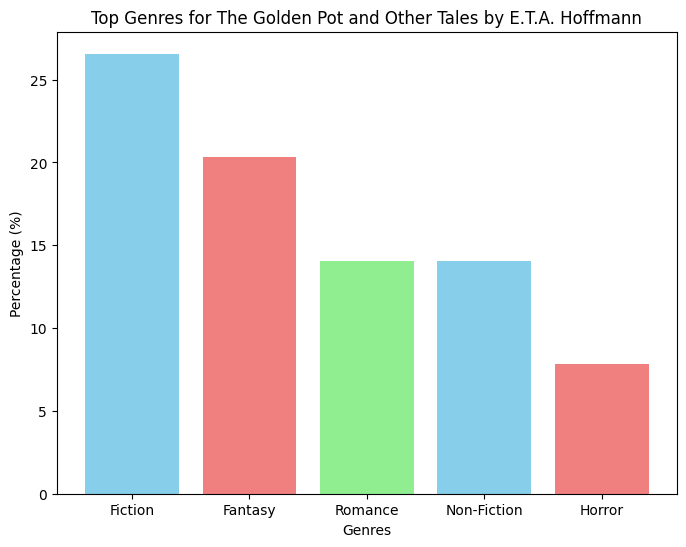

Predicted Genres:
Fiction: 17 matches (26.56%)
Fantasy: 13 matches (20.31%)
Romance: 9 matches (14.06%)
Non-Fiction: 9 matches (14.06%)
Horror: 5 matches (7.81%)


In [46]:
import matplotlib.pyplot as plt


book_url = "https://www.goodreads.com/book/show/551457/reviews?reviewFilters=eyJhZnRlciI6Ik5URXNNVFkzTVRrMU56ZzROekF6TWcifQ%3D%3D"  # Replace with a valid Goodreads book URL
top_genres = get_book_genres_from_reviews(book_url, num_reviews=10, top_n=5)
reviews = scrape_goodreads_reviews_selenium(book_url, num_reviews=50)
actualTitle = reviews[0].split(" book reviews ")[0]
print(actualTitle)

if top_genres:
    genres = [genre for genre, score, percentage in top_genres]
    percentages = [percentage for genre, score, percentage in top_genres]

    plt.figure(figsize=(8, 6))
    plt.bar(genres, percentages, color=['skyblue', 'lightcoral', 'lightgreen'])
    plt.xlabel("Genres")
    plt.ylabel("Percentage (%)")
    plt.title(f"Top Genres for {actualTitle}")
    plt.show()

if top_genres:
    print("Predicted Genres:")
    for genre, score, percentage in top_genres:
        print(f"{genre}: {score} matches ({percentage:.2f}%)")